In [ ]:
#%run  surrogate_agg.ipynb
%run  surrogate_score.ipynb

In [ ]:
def sur_weighted_aggr(preds, sur_score_matrix, ifps_type=None):
    n, m, k = preds.shape
    if ifps_type is None:
        ifps_type = 2 * np.ones(n)
    sur_weighted_pred = -1 * np.ones((n, k))
    #ind_mean_sur_score = np.nanmean(sur_score_matrix, axis=0) 
    scaled_score = np.array(sur_score_matrix) 
    ### for Brier Score
    #scaled_score[scaled_score==-1] = np.NAN
    #scaled_score = 2-scaled_score
    ### for sur score (sur score contains negetive values)
    scaled_score = ((np.nanmax(scaled_score, axis=1)[:, None] - scaled_score) / 
                    (np.nanmax(scaled_score, axis=1)[:, None]-np.nanmin(scaled_score, axis=1)[:, None])) * 2
    scaled_score = scaled_score - (np.nanmedian(scaled_score, axis=1)[:, None]
                                   -np.abs(np.nanmedian(scaled_score, axis=1)[:, None])*0.3)
    ind_mean_sur_score = np.nansum(scaled_score, axis=0)
        
    
    for i in range(n):
        curr_pred = preds[i]
        curr_score = np.array(ind_mean_sur_score)
        curr_score[np.isnan(curr_score) | np.isnan(curr_pred[:, 0])] = -1000
        user_seq = np.argsort(curr_score)
            
        num_answerred_users = np.sum(curr_score>-1000)
        threshold = np.min([np.max([np.min([int(np.ceil(num_answerred_users*0.1)), 20]), 5]),
                            num_answerred_users])
        #print(i, ifps_type[i], num_answerred_users, threshold, np.sum(~np.isnan(ind_mean_sur_score)))
        if threshold<=0: continue
        #print(curr_pred[user_seq[-threshold:]][:, 0])
        #print(curr_pred[user_seq[-num_answerred_users:]][:, 0])
        curr_pred = curr_pred[user_seq[-threshold:]]
        weights = curr_score[user_seq[-threshold:]]
        if (np.max(weights)-np.min(weights)!=0.):
            weights = (weights - np.min(weights))/(np.max(weights)-np.min(weights))
        weights = np.exp(weights)
        sur_weighted_pred[i] = np.average(curr_pred, weights=weights, axis=0)
        #sur_weighted_pred[i] = median_aggr(curr_pred[None, :,:]).squeeze()
        #sur_weighted_pred[i] = entropy_weighted_aggr(curr_pred[None, :,:], ifps_type=[ifps_type[i]])
        #sur_weighted_pred[i] = conf_weighted_aggr(curr_pred[None, :,:], 
        #                                          conf[i, user_seq[-threshold:]][None, :])
        #print(sur_weighted_pred[i])
    #print(np.isnan(scaled_score).any())
    return sur_weighted_pred

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

save_file = open('daily_HFC_multi_outcome_data_matrix_all.npy','rb')
raw_indicator = np.load(save_file)
raw_preds = np.load(save_file)
raw_conf = np.load(save_file)
raw_wager = np.load(save_file)
raw_se = np.load(save_file)
raw_truth = np.load(save_file)
raw_openday = np.load(save_file)
raw_user_type = np.load(save_file)
save_file.close()

ifps_data = pd.read_csv("ifps0726_resolved.csv")
raw_ifps_type = ifps_data['type'].values


save_file = open('daily_HFC_data_matrix_agg.npy','rb')
agg_preds = np.load(save_file)
agg_se = np.load(save_file)
#agg_openday = np.load(save_file)
## Truth a vector of {1,2} where 1 means the event happen with probability 1
#truth = np.load(save_file)
save_file.close()

In [215]:
openday = raw_openday[:]
ifps_type = raw_ifps_type[:]
truth = raw_truth[:]


#valid = raw_user_type==1
#valid = raw_user_type==2
#valid = raw_user_type==3
valid = raw_user_type>0
#indicator = raw_indicator[:, :, valid]
preds = raw_preds[:, :, valid]
conf = raw_conf[:, :, valid]
wager = raw_wager[:, :, valid]
se = raw_se[:, :, valid]
user_type = raw_user_type[valid]


#print(preds)
print(ifps_type)
print(truth)
print(preds.shape)
print(conf.shape)
print(wager.shape)
print(se.shape)
print(openday.shape)
print(agg_preds.shape)
#print(openday[35:70].T)
#print(agg_openday[35:70].T)
#print(ifps_data[['map_id','type']])

[5 3 5 5 3 5 5 5 2 5 5 2 5 5 3 5 5 2 2 5 5 5 5 5 5 5 5 2 2 5 2 2 4 2 2 2 2
 2 4 3 2 2 2 2 3 5 2 5 2 2 3 4 3 2 2 3 5 2 3 2 2 3 2 2 5 2 5 2 2 2 3 5 2 2
 5 5 3 2 2 2 5 4 2 5 5 2]
[3 1 4 4 2 5 2 2 2 5 3 2 4 1 2 5 1 1 1 5 4 1 1 3 2 2 5 2 2 3 1 2 4 2 2 1 2
 1 1 2 1 2 2 1 1 3 2 4 2 1 2 1 3 1 1 1 4 1 1 2 1 2 1 1 5 2 3 2 2 2 1 3 2 2
 3 2 1 1 1 1 1 1 1 2 4 1]
(141, 86, 2094, 5)
(141, 86, 2094)
(141, 86, 2094)
(141, 86, 2094)
(141, 86)
(184, 26, 47)


In [5]:
from scipy.spatial.distance import cdist, euclidean
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [209]:
def MBS(preds, truth):
    truth = truth - 1
    preds[preds<-0.1] = np.NAN
    if np.sum(~np.isnan(preds))<=0:
        return np.NAN, np.ones(len(truth)) * np.NAN
    #preds_of_true_label = preds[np.arange(len(truth))[:, None], truth[:, None]].squeeze()
    preds_of_true_label = preds[np.arange(len(truth))[:, None], truth[:, None]].flatten()
    score = np.sum(preds**2, axis=-1) - preds_of_true_label**2 + (1-preds_of_true_label)**2
    return np.nanmean(score), score

def mean_aggr(preds):
    return np.nanmean(preds, axis=1)

def median_aggr(preds):
    n, m, k = preds.shape
    median_pred = -np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i, :, 0])
        median_pred[i] = geometric_median(preds[i, users, :])
    return median_pred

def majority_aggr(preds):
    n, m, k = preds.shape
    major_pred = np.zeros((n, k))
    major_pred[np.arange(n)[:, None], np.argmax(np.nanmean(preds, axis=1), axis=-1)[:, None]] = 1.0
    return major_pred

def logit_aggr(preds, ifps_type=None, para={2: 1.4, 3: 1.4, 4: 1.4, 5: 1.4}):
    n, m, k = preds.shape
    if ifps_type is None: ifps_type = 2 * np.ones(n)
    logit_pred = -1 * np.ones((n, k))
    for i in range(n):
        num_outcome = int(ifps_type[i])
        a = para[num_outcome]
        curr_pred = preds[i, preds[i, :, 0]>-0.1, :]
        if (np.sum(curr_pred[:, 0]>-0.1)<=0): continue
        logit_pred[i] = 0
        base_dim = 0#ifps_type[i] - 1
        logits = np.array(curr_pred).T
        logits[base_dim, logits[base_dim]>=1] = 0.999
        logits[base_dim, logits[base_dim]<=0] = 0.001
        logit_pred[i, base_dim] = 1
        for k in range(0, num_outcome):
            if k==base_dim: continue
            logits[k, logits[k]>=1] = 0.999
            logits[k, logits[k]<=0] = 0.001
            logits[k] = np.log(logits[k]/logits[base_dim])
            mean = np.mean(logits[k])
            logit_pred[i, k] = np.exp(a * mean)
        logit_pred[i] = logit_pred[i] / np.sum(logit_pred[i])
        #print("qid: ", i, "type: ", ifps_type[i], "logit: ", logit_pred[i])
        
    return logit_pred

def entropy_matrix(pred_matrix, axis=-1):
    type_matrix = np.zeros_like(pred_matrix)
    type_matrix[pred_matrix<0] = -1
    type_matrix[(pred_matrix>0) & (pred_matrix<1)] = 1
    entropy_matrix = np.array(pred_matrix)
    entropy_matrix[type_matrix<1] = 0.5
    entropy_matrix = -entropy_matrix * np.log(entropy_matrix)
    entropy_matrix[type_matrix==0] = 0
    entropy_matrix[type_matrix==-1] = np.NAN
    return np.sum(entropy_matrix, axis=axis)
    
    
def prob_weighted_aggr(preds, openday):
    n, m = preds.shape
    prob_weighted_pred = -1 * np.ones(n)
    for i in range(n):
        if openday[i]==0: continue
        if (np.sum(preds[i, :]>-0.1)<=0): continue
        probs = preds[i, :]
        probs = probs[probs>-0.1]
        prob_weighted_pred[i] = np.average(probs, weights=np.abs(probs-0.5))
    return prob_weighted_pred

def entropy_weighted_aggr(preds, ifps_type):
    n, m, k = preds.shape
    entr_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i,:,0])
        curr_pred = preds[i, users]
        entr_weights = entropy_matrix(curr_pred)
        entr_weights = (np.log(ifps_type[i]) - entr_weights) / np.log(ifps_type[i])
        entr_weights = entr_weights ** 4
        entr_weighted_pred[i] = np.average(curr_pred, weights=entr_weights, axis=0)
    return entr_weighted_pred

def conf_weighted_aggr(preds, conf):
    n, m, k = preds.shape
    conf_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i,:,0])
        curr_conf = conf[i, users]
        curr_pred = preds[i, users]
        if np.sum(curr_conf)<=0: continue
        conf_weighted_pred[i] = np.average(curr_pred, weights=curr_conf, axis=0)
    return conf_weighted_pred

def top_conf_aggr(preds, conf, top=10):
    n, m, k = preds.shape
    conf_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        valid = ~np.isnan(preds[i,:,0])
        curr_conf = conf[i, valid]
        curr_pred = preds[i, valid]
        if np.sum(curr_conf>=80)>=top:
            users = (curr_conf>=80)
        elif np.sum(curr_conf>=70)>=top:
            users = (curr_conf>=70)
            #print("conf:", i, 70, np.sum(conf[i, :]>=80))
        elif np.sum(curr_conf>50)>=top:
            users = (curr_conf>50)
        elif np.sum(curr_conf>=50)>=top:
            users = (curr_conf>=50)
        else: users = (curr_conf>=0)
        if np.sum(users)<=0: continue
        curr_conf = curr_conf[users]
        curr_pred = curr_pred[users]
        if np.max(curr_conf)<=0.0:
            curr_conf[:] = 1
        elif np.max(curr_conf)-np.min(curr_conf)>0:
            curr_conf = (curr_conf - np.min(curr_conf)) / (np.max(curr_conf)-np.min(curr_conf))
        conf_weighted_pred[i] = np.average(curr_pred, weights=curr_conf, axis=0)
    return conf_weighted_pred

def wager_weighted_aggr(preds, wager, wager_option):
    n, m, k = preds.shape
    wager_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i,:,0])
        curr_wager = wager[i, users] + 10 * wager_option[users]
        #print(curr_wager)
        if np.sum(curr_wager>0)<=0: continue
        curr_pred = preds[i, users]
        wager_weighted_pred[i] = np.average(curr_pred, weights=curr_wager, axis=0)
    return wager_weighted_pred

def top_wager_aggr(preds, wager, wager_option, base_weight=5):
    n, m, k = preds.shape
    wager_weighted_pred = -1 * np.ones((n, k))
    for i in range(n):
        users = ~np.isnan(preds[i,:,0])
        curr_wager = wager[i, users]
        curr_wager[curr_wager==100] = base_weight
        curr_wager[curr_wager==0] = base_weight
        num_wagered_users = np.sum(curr_wager>0)
        if num_wagered_users<=0: continue
        order = np.argsort(curr_wager)
        curr_wager[order[:-10]] = 0
        curr_pred = preds[i, users]
        wager_weighted_pred[i] = np.average(curr_pred, weights=curr_wager, axis=0)
    return wager_weighted_pred

def openday_filter(preds, openday):
    n, m = preds.shape
    new_preds = -1 * np.ones_like(preds)
    for i in range(n):
        if openday[i]==0: continue
        new_preds[i] = preds[i]
    return new_preds

In [220]:
t, n, m, k = preds.shape
print(t, n, m, k)
num = np.zeros((t,n))
BS_mean = np.NAN * np.ones((t, n))
MBS_mean = np.NAN * np.ones(t)
BS_median = np.NAN * np.ones((t, n))
MBS_median = np.NAN * np.ones(t)
BS_logit = np.NAN * np.ones((t, n))
MBS_logit = np.NAN * np.ones(t)
BS_prob_weighted = np.NAN * np.ones((t, n))
MBS_prob_weighted = np.NAN * np.ones(t)
BS_entr_weighted = np.NAN * np.ones((t, n))
MBS_entr_weighted = np.NAN * np.ones(t)
BS_conf_weighted = np.NAN * np.ones((t, n))
MBS_conf_weighted = np.NAN * np.ones(t)
BS_top_conf = np.NAN * np.ones((t, n))
MBS_top_conf = np.NAN * np.ones(t)
BS_wager_weighted = np.NAN * np.ones((t, n))
MBS_wager_weighted = np.NAN * np.ones(t)
BS_top_wager = np.NAN * np.ones((t, n))
MBS_top_wager = np.NAN * np.ones(t)
BS_major = np.NAN * np.ones((t, n))
MBS_major = np.NAN * np.ones(t)
BS_sur1_majority_happen = np.NAN * np.ones((t, n))
MBS_sur1_majority_happen = np.NAN * np.ones(t)
BS_sur1_minority_happen = np.NAN * np.ones((t, n))
MBS_sur1_minority_happen = np.NAN * np.ones(t)
BS_sur2_majority_happen = np.NAN * np.ones((t, n))
MBS_sur2_majority_happen = np.NAN * np.ones(t)
BS_sur2_minority_happen = np.NAN * np.ones((t, n))
MBS_sur2_minority_happen = np.NAN * np.ones(t)
SE = np.NAN * np.ones((t, n))

l = agg_preds.shape[-1]
BS_agg = np.NAN * np.ones((l, t, n))
MBS_agg = np.NAN * np.ones((l, t))

sur_error_rate_days = 0
for i in range(t):
    if i%20==0: print(i)
    curr_pred = np.array(preds[i])
    num[i] = np.sum(curr_pred[:, :, 0]>-0.1, axis=1)*openday[i]
    answered_ifps = num[i]>0
    if np.sum(answered_ifps)<=0: continue
    
    curr_pred = curr_pred[answered_ifps, :, :]
    curr_pred[curr_pred<-0.1] = np.NAN
    for j in range(len(curr_pred)):
        while (np.sum(~np.isnan(curr_pred[j, :, 0]))>26):
            index = np.argwhere(~np.isnan(curr_pred[j, :, 0]))
            curr_pred[j, index[int(np.random.randint(0, len(index)))], :] = np.NAN
    
    mean_pred = -np.ones((n, k))
    median_pred = -np.ones((n, k))
    logit_pred = -np.ones((n, k))
    entr_weighted_pred = -np.ones((n, k))
    conf_weighted_pred = -np.ones((n,k))
    top_conf_pred = -np.ones((n,k))
    wager_weighted_pred = -np.ones((n,k))
    top_wager_pred = -np.ones((n,k))
    major_pred = -np.ones((n,k))
    
    mean_pred[answered_ifps] = mean_aggr(curr_pred)
    median_pred[answered_ifps] = median_aggr(curr_pred)
    logit_pred[answered_ifps] = logit_aggr(curr_pred, ifps_type[answered_ifps])
    entr_weighted_pred[answered_ifps] = entropy_weighted_aggr(curr_pred, ifps_type[answered_ifps])
    conf_weighted_pred[answered_ifps] = conf_weighted_aggr(curr_pred, conf[i][answered_ifps,:])
    top_conf_pred[answered_ifps] = conf_weighted_aggr(curr_pred, conf[i][answered_ifps,:])
    wager_weighted_pred[answered_ifps] = wager_weighted_aggr(curr_pred, wager[i][answered_ifps,:], user_type<3)
    top_wager_pred[answered_ifps] = wager_weighted_aggr(curr_pred, wager[i][answered_ifps,:], user_type<3)
    major_pred[answered_ifps] = majority_aggr(curr_pred)
    
    MBS_mean[i], BS_mean[i] = MBS(mean_pred, truth)
    MBS_median[i], BS_median[i] = MBS(median_pred, truth)
    MBS_logit[i], BS_logit[i] = MBS(logit_pred, truth)
    MBS_entr_weighted[i], BS_entr_weighted[i] = MBS(entr_weighted_pred, truth)
    MBS_conf_weighted[i], BS_conf_weighted[i] = MBS(conf_weighted_pred, truth)
    MBS_top_conf[i], BS_top_conf[i] = MBS(top_conf_pred, truth)
    MBS_wager_weighted[i], BS_wager_weighted[i] = MBS(wager_weighted_pred, truth)
    MBS_top_wager[i], BS_top_wager[i] = MBS(top_wager_pred, truth)
    MBS_major[i], BS_major[i] = MBS(major_pred, truth)
    
    #multi_preds_ifps = np.sum(preds[i]>-0.1, axis=1)>=3
    #if (sur_error_rate_days<10 or sur_error_rate_days%10==0) and np.sum(multi_preds_ifps)>0:
    #    print("day: "+str(i))
    #    err_ind_majority_happen, P0_est_majority_happen = sur_error_rate(preds[i][multi_preds_ifps,:], P0=0.51)
    #    err_ind_minority_happen, P0_est_minority_happen = sur_error_rate(preds[i][multi_preds_ifps,:], P0=0.49)
        
    #if not (np.isnan(P0_est_majority_happen) or np.isnan(P0_est_minority_happen)):            
    #    sur_error_rate_days += 1
    #    curr_open_preds = openday_filter(np.array(preds[i]), openday[i])
    #    sur1_pred_majority_happen = sur_agg_1(curr_open_preds, err_ind_majority_happen, P0_est_majority_happen)
    #    sur1_pred_minority_happen = sur_agg_1(curr_open_preds, err_ind_minority_happen, P0_est_minority_happen)
    #    sur2_pred_majority_happen = sur_agg_2(curr_open_preds, err_ind_majority_happen)
    #    sur2_pred_minority_happen = sur_agg_2(curr_open_preds, err_ind_minority_happen)
    #    sur1_pred_majority_happen[sur1_pred_majority_happen>1] = 1
    #    sur1_pred_minority_happen[sur1_pred_minority_happen>1] = 1
    #    sur2_pred_majority_happen[sur2_pred_majority_happen>1] = 1
    #    sur2_pred_minority_happen[sur2_pred_minority_happen>1] = 1
    #    MBS_sur1_majority_happen[i], BS_sur1_majority_happen[i] = MBS(sur1_pred_majority_happen, truth)         
    #    MBS_sur1_minority_happen[i], BS_sur1_minority_happen[i] = MBS(sur1_pred_minority_happen, truth)
    #    MBS_sur2_majority_happen[i], BS_sur2_majority_happen[i] = MBS(1.0*sur2_pred_majority_happen, truth)
    #    MBS_sur2_minority_happen[i], BS_sur2_minority_happen[i] = MBS(1.0*sur2_pred_minority_happen, truth)
        
        
    #openday_agg_preds = openday_filter(np.array(agg_preds[i]), openday[i])
    #for j in range(l):
    #    MBS_agg[j, i], BS_agg[j, i, :] = MBS(openday_agg_preds[:, j], truth)


141 86 2094 5
0
20
40
60
80
100
120
140


In [221]:
num_matrix = np.zeros((t, n))
for i in range(t):
    num_matrix[i, :] = np.sum(conf[i, :, :]>-0.1, axis=1)

In [227]:
import scipy.stats as st

cuts = np.linspace(0,1,11)
BS_cut_matrix = np.ones((8, len(cuts), n)) * np.NAN

num_preds = np.ones(n) * np.NAN
days = np.zeros(n)

for i in range(n):
    BS_matrix_one_IFP = np.vstack((BS_mean[:, i], BS_median[:, i], BS_logit[:, i], BS_entr_weighted[:, i],
                                   BS_conf_weighted[:, i], BS_top_conf[:, i],
                                   BS_wager_weighted[:, i], BS_top_wager[:, i]
                                  ))
    num_methods = len(BS_matrix_one_IFP)
    days[i] = np.sum(~np.isnan(BS_matrix_one_IFP[0,:]))
    if days[i]<=13: continue
    tmp_mean_scores = np.zeros(num_methods)
    for j in range(num_methods):
        tmp = BS_matrix_one_IFP[j, :]
        valid = ~np.isnan(tmp)
        tmp = tmp[valid]
        tmp_days = len(tmp)
        for c in range(len(cuts)):
            BS_cut_matrix[j, c, i] = tmp[int(np.round(cuts[c]*(tmp_days-1)))]
epoch += 1
total_BS_cut_matrix += BS_cut_matrix
print(epoch)

23


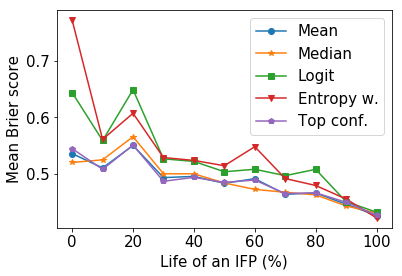

In [230]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

plot_BS_cut_matrix = total_BS_cut_matrix[:]/epoch
plt.figure(1)
labels = ['Mean', 'Median', 'Logit', 'Entropy w.', 'Conf w.', 'Top conf.']
markers = ['o', '*', 's', 'v', '^','p']
for i in [0, 1, 2, 3, 5]:
    x = cuts * 100
    y = np.nanmean(BS_cut_matrix[i], axis=1)
    #print(y)
    plt.plot(x, y, '-'+markers[i], label=labels[i])
plt.legend()
plt.xlabel('Life of an IFP (%)')
plt.ylabel('Mean Brier score')
plt.savefig("/Users/heliaguin/Desktop/11.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()
plt.close('All')

In [131]:
epoch=0
total_BS_cut_matrix = np.zeros_like(BS_cut_matrix)
print(total_BS_cut_matrix.shape)

(8, 11, 86)


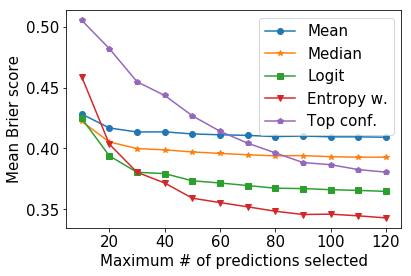

In [226]:
BS_num_matrix = np.zeros((8, 121))
BS_num_matrix[:, 10] = np.array([ 0.4283,0.4222,0.4247,0.459, 0.5053,0.5053,0.4346,0.4346])
BS_num_matrix[:, 20] = np.array([ 0.4168,0.4053,0.3939,0.4035,0.482, 0.482, 0.4215,0.4215])
BS_num_matrix[:, 30] = np.array([ 0.4135,0.3999,0.3804,0.3804,0.4548,0.4548,0.4145,0.4145])
BS_num_matrix[:, 40] = np.array([ 0.4136,0.3988,0.3793,0.3716,0.4435,0.4435,0.4262,0.4262])
BS_num_matrix[:, 50] = np.array([ 0.4119,0.3971,0.3734,0.3591,0.4268,0.4268,0.4218,0.4218])
BS_num_matrix[:, 60] = np.array([ 0.4112,0.3959,0.3716,0.3555,0.4141,0.4141,0.4184,0.4184])
BS_num_matrix[:, 70] = np.array([ 0.4107,0.3948,0.3695,0.352, 0.4043,0.4043,0.4157,0.4157])
BS_num_matrix[:, 80] = np.array([ 0.4097,0.3939,0.3673,0.3484,0.3963,0.3963,0.4138,0.4138])
BS_num_matrix[:, 90] = np.array([ 0.4102,0.3941,0.367, 0.3457,0.3884,0.3884,0.4097,0.4097])
BS_num_matrix[:, 100] = np.array([ 0.4095,0.3932,0.3661,0.346, 0.3866,0.3866,0.4079,0.4079])
BS_num_matrix[:, 110] = np.array([ 0.4095,0.3928,0.3655,0.3446,0.3826,0.3826,0.4094,0.4094])
BS_num_matrix[:, 120] = np.array([ 0.4092,0.3928,0.3647,0.3429,0.3805,0.3805,0.4067,0.4067])

x = [(i+1)* 10 for i in range(12)]
plt.figure(1)
labels = ['Mean', 'Median', 'Logit', 'Entropy w.', 'Conf w.', 'Top conf.']
markers = ['o', '*', 's', 'v', '^','p']
for i in [0, 1, 2, 3, 5]:
    y = BS_num_matrix[i][x]
    #print(y)
    plt.plot(x, y, '-'+markers[i], label=labels[i])
plt.legend()
plt.xlabel('Maximum # of predictions selected')
plt.ylabel('Mean Brier score')
plt.savefig("/Users/heliaguin/Desktop/2.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()
plt.close('All')

In [88]:
import scipy.stats as st
#BS_mean_open = np.ones(n) * np.NAN
#BS_median_open = np.ones(n) * np.NAN
#BS_logit_open = np.ones(n) * np.NAN
#BS_entr_open = np.ones(n) * np.NAN
#BS_conf_weighted_open = np.ones(n) * np.NAN
#BS_top_conf_open = np.ones(n) * np.NAN
#BS_wager_weighted_open = np.ones(n) * np.NAN
#BS_top_wager_open = np.ones(n) * np.NAN

num_preds = np.ones(n) * np.NAN
BS_period_matrix = []
days = np.zeros(n)

for i in range(n):
    BS_matrix_one_IFP = np.vstack((BS_mean[:, i], BS_median[:, i], BS_logit[:, i], BS_entr_weighted[:, i],
                                   BS_conf_weighted[:, i], BS_top_conf[:, i],
                                   BS_wager_weighted[:, i], BS_top_wager[:, i]
                                  ))
    num_methods = len(BS_matrix_one_IFP)
    days[i] = np.sum(~np.isnan(BS_matrix_one_IFP[0,:]))
    if days[i]<=13: continue
    tmp_mean_scores = np.zeros(num_methods)
    for j in range(num_methods):
        tmp = BS_matrix_one_IFP[j, :]
        valid = ~np.isnan(tmp)
        tmp = tmp[valid]
        tmp_days = len(tmp)
        #tmp = tmp[:int(np.round(0.5*tmp_days))]
        #tmp = tmp[int(np.round(0.7*tmp_days)):]
        tmp = tmp[-1].reshape((-1))
        tmp_mean_scores[j] = np.mean(tmp)
        num_preds[i] = np.sum(num_matrix[valid, i][0])/ len(tmp)
    BS_period_matrix.append(tmp_mean_scores)
BS_period_matrix = np.array(BS_period_matrix)
print(BS_period_matrix.shape)
print(np.mean(BS_period_matrix, axis=0))

print("p value:")
p_values = np.zeros(num_methods)
for i in range(num_methods):
    tmp, p_values[i] = st.ttest_1samp(BS_period_matrix[:, 0] - BS_period_matrix[:, i], popmean=0)
p_values /= 2
p_values[p_values<=0.05] = 1
print(p_values)
for i in range(num_methods):
    tmp, p_values[i] = st.ttest_1samp(BS_period_matrix[:, 3] - BS_period_matrix[:, i], popmean=0)
p_values /= 2
p_values[p_values<=0.05] = 1
print(p_values)
print(np.nansum(num_preds)/np.nansum(num_preds>0))

(66, 8)
[ 0.4251  0.408   0.41    0.4345  0.426   0.426   0.4905  0.4905]
p value:
[    nan  0.108   0.2987  0.4155  0.3892  0.3892  1.      1.    ]
[ 0.4155  0.2911  0.2549     nan  0.4224  0.4224  0.1384  0.1384]
26.4848484848


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less_equal
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less_equal
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


In [84]:
print(str(days).replace('.', ','))

[  43,   48,    3,   16,   48,   79,  116,   25,   86,   18,   86,    5,
   12,   55,   25,   86,   25,   33,   27,    8,  114,    5,   53,   41,
   75,   33,   34,   65,   95,   82,   36,   88,   60,   88,   58,   16,
   99,   35,   58,   81,    3,   51,   12,   86,   29,   44,   74,   43,
   74,   19,   43,   68,   67,    3,   75,   67,   30,   36,   34,   64,
   23,   15,    0,    7,    7,    7,    7,    7,    4,    7,    6,   16,
    7,    7,   39,   39,   32,   39,   21,   20,   29,   15,    3,   23,
   20,   23,]


In [10]:
start_day = 0
print(np.array([np.nanmean([np.nanmean(BS_mean[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_median[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_logit[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_entr_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_conf_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_top_conf[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_wager_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_top_wager[start_day:, i]) for i in range(n)])
#                np.nanmean([np.nanmean(BS_sur1_majority_happen[start_day:, i]) for i in range(n)]),
#                np.nanmean([np.nanmean(BS_sur1_minority_happen[start_day:, i]) for i in range(n)]),
#                np.nanmean([np.nanmean(BS_sur2_majority_happen[start_day:, i]) for i in range(n)]),
#                np.nanmean([np.nanmean(BS_sur2_minority_happen[start_day:, i]) for i in range(n)])
               ]))

[ 0.4697  0.4712  0.4944  0.4761  0.471   0.471   0.5307  0.5307]


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/heliaguin/anaconda/lib/python3.6/site-

In [ ]:
def aaa(pred_matrix, P0, trials = 100):
    n, m = pred_matrix.shape
    #agg_pred = logit_aggr(pred_matrix)
    tmp = np.array(pred_matrix)
    tmp[tmp<-0.1] = np.NAN
    agg_pred = np.nanmean(tmp, axis=1)
    agg_labels_multi_trials = np.zeros((n, trials))
    for i in range(trials):
        labels = 2 - (np.random.rand(n) < agg_pred)
        agg_labels_multi_trials[:, i] = labels
    agg_labels_multi_trials[:, 0] = 2 - (0.5 < agg_pred)
    #print(agg_labels_multi_trials[:, 0])
    #print(agg_labels_multi_trials.shape)
    #print(agg_labels_multi_trials)
    err_ind, P0_est = sur_error_rate(pred_matrix, eval_labels=agg_labels_multi_trials, P0=P0)
    #err_ind, P0_est = sur_error_rate(last_pred, eval_labels=agg_labels_multi_trials[:, 0][:,None], P0=0.49)
    err_ind = np.array(err_ind)
    err_agg = np.mean(err_ind, axis=0)
    print(err_agg)
    if np.isnan(err_agg).any():
        return np.ones_like(pred_matrix) * np.NAN, err_agg
    #print(err_ind.shape)
    #print(err_ind)
    #print(P0_est)
    
    sur_score_matrix = estimate_sur_score(pred_matrix, agg_pred, err_agg)
    #print(np.min(sur_score_matrix[~np.isnan(sur_score_matrix)]),
    #      np.max(sur_score_matrix[~np.isnan(sur_score_matrix)]))
    print(np.nanmean(sur_score_matrix))
    #print(sur_score_matrix)
    #sur_score = estimate_sur_score(np.array(1 * (0.5 < agg_pred))[:, None], agg_pred[:], err_agg)
    #sur_score = estimate_sur_score(0.5 * np.ones((n,1)), agg_pred, err_agg)
    #print(sur_score)
    #print(np.mean(sur_score))
    return sur_score_matrix, err_agg

t, n, m, k = preds.shape
print(t, n, m, k)
num = np.zeros((t,n))
BS_sur_weighted_maj = np.NAN * np.ones((t, n))
MBS_sur_weighted_maj = np.NAN * np.ones(t)
BS_sur_weighted_min = np.NAN * np.ones((t, n))
MBS_sur_weighted_min = np.NAN * np.ones(t)
BS_logit = np.NAN * np.ones((t, n))
MBS_logit = np.NAN * np.ones(t)
BS_mean = np.NAN * np.ones((t, n))
MBS_mean = np.NAN * np.ones(t)
sur_error_rate_days = 0
for i in range(t):
    if i%20==0: print(i)
    curr_pred = np.array(preds[i])
    num[i] = np.sum(curr_pred[:, :, 0]>-0.1, axis=1)*openday[i]
    answered_ifps = num[i]>0
    if np.sum(answered_ifps)<=0: continue
    
    curr_pred = curr_pred[answered_ifps, :, :]
    curr_pred[curr_pred<-0.1] = np.NAN
    
    mean_pred = -np.ones((n, k))
    logit_pred = -np.ones((n, k))
    sur_weighted_pred_maj = -np.ones((n, k))
    sur_weighted_pred_min = -np.ones((n, k)) 
    
    mean_pred[answered_ifps] = mean_aggr(curr_pred)
    logit_pred[answered_ifps] = logit_aggr(curr_pred, ifps_type[answered_ifps])
    
    MBS_logit[i], BS_logit[i] = MBS(logit_pred, truth)
    MBS_mean[i], BS_mean[i] = MBS(mean_pred, truth)
    
    # using all predictions including those closed to calculate error rate
    valid_ifps = (ifps_type == 2) & (np.sum(preds[i, :, :, 0]>-0.1, axis=1)>=3)
    print("sur_day", sur_error_rate_days)
    if np.sum(valid_ifps)>0:
        sur_error_rate_days += 1
    if sur_error_rate_days>=30 and sur_error_rate_days%10==0 and np.sum(valid_ifps)>0:
        print("day: "+str(i))
        valid_preds = np.array(preds[i, valid_ifps, :, 0])
        valid_preds = valid_preds.reshape((np.sum(valid_ifps), -1))
        sur_score_matrix_maj, err_agg_maj = aaa(valid_preds, P0=0.51)
        sur_score_matrix_min, err_agg_min = aaa(valid_preds, P0=0.49)
    #    err_agg_minority = aaa(valid_preds, P0=0.49)
    #    err_ind_minority_happen, P0_est_minority_happen = sur_error_rate(preds[i][multi_preds_ifps,:], P0=0.49)

        
    if (~np.isnan(err_agg_maj).any()) and (np.sum(err_agg_maj)<0.55) and (sur_error_rate_days>=30):
        sur_weighted_pred_maj[answered_ifps] = sur_weighted_aggr(curr_pred, sur_score_matrix_maj,
                                                                 ifps_type[answered_ifps])
        MBS_sur_weighted_maj[i], BS_sur_weighted_maj[i] = MBS(sur_weighted_pred_maj, truth)
        print('Day '+str(i)+" logit MBS:", MBS_logit[i])
        print('Day '+str(i)+" sur maj MBS:", MBS_sur_weighted_maj[i]," sur BS:", BS_sur_weighted_maj[i])
    else: sur_weighted_pred_maj[answered_ifps] = mean_pred[answered_ifps]
    
    if (~np.isnan(err_agg_min).any()) and (np.sum(err_agg_min)<0.55) and (sur_error_rate_days>=30):
        sur_weighted_pred_min[answered_ifps] = sur_weighted_aggr(curr_pred, sur_score_matrix_min,
                                                                 ifps_type[answered_ifps])
        MBS_sur_weighted_min[i], BS_sur_weighted_min[i] = MBS(sur_weighted_pred_min, truth)
        print('Day '+str(i)+" logit MBS:", MBS_logit[i])
        print('Day '+str(i)+" sur min MBS:", MBS_sur_weighted_min[i]," sur BS:", BS_sur_weighted_min[i])
    else: sur_weighted_pred_min[answered_ifps] = mean_pred[answered_ifps]
        
    MBS_sur_weighted_maj[i], BS_sur_weighted_maj[i] = MBS(sur_weighted_pred_maj, truth)
    MBS_sur_weighted_min[i], BS_sur_weighted_min[i] = MBS(sur_weighted_pred_min, truth)
    #    curr_open_preds = openday_filter(np.array(preds[i]), openday[i])
    #    sur1_pred_majority_happen = sur_agg_1(curr_open_preds, err_ind_majority_happen, P0_est_majority_happen)
    #    sur1_pred_minority_happen = sur_agg_1(curr_open_preds, err_ind_minority_happen, P0_est_minority_happen)
    #    sur2_pred_majority_happen = sur_agg_2(curr_open_preds, err_ind_majority_happen)
    #    sur2_pred_minority_happen = sur_agg_2(curr_open_preds, err_ind_minority_happen)
    #    sur1_pred_majority_happen[sur1_pred_majority_happen>1] = 1
    #    sur1_pred_minority_happen[sur1_pred_minority_happen>1] = 1
    #    sur2_pred_majority_happen[sur2_pred_majority_happen>1] = 1
    #    sur2_pred_minority_happen[sur2_pred_minority_happen>1] = 1
    #    MBS_sur1_majority_happen[i], BS_sur1_majority_happen[i] = MBS(sur1_pred_majority_happen, truth)         
    #    MBS_sur1_minority_happen[i], BS_sur1_minority_happen[i] = MBS(sur1_pred_minority_happen, truth)
    #    MBS_sur2_majority_happen[i], BS_sur2_majority_happen[i] = MBS(1.0*sur2_pred_majority_happen, truth)
    #    MBS_sur2_minority_happen[i], BS_sur2_minority_happen[i] = MBS(1.0*sur2_pred_minority_happen, truth)



In [ ]:
start_day = 0
print(np.array([np.nanmean([np.nanmean(BS_sur_weighted_maj[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_sur_weighted_min[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_logit[start_day:, i]) for i in range(n)])
               ]))


In [ ]:
start_day = 0
print(np.array([np.nanmean([np.nanmean(BS_mean[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_median[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_logit[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_entr_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_conf_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_wager_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_major[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_sur_weighted_maj[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_sur_weighted_min[start_day:, i]) for i in range(n)])
               ]))


baseline = np.array([np.nanmean(BS_mean[start_day:, i]) for i in range(n)])
sur = np.array([np.nanmean(BS_sur_weighted_maj[start_day:, i]) for i in range(n)])
valid = (~np.isnan(baseline)) & (~np.isnan(sur))
baseline = baseline[valid]
sur = sur[valid]
t_score, p_value = st.ttest_1samp(sur - baseline, popmean=0)
p_value = p_value / 2
print("t, p value(one_tail): ", t_score, p_value)

#print(BS_conf_weighted[:, :7])

In [9]:
#num[num==0] = np.NAN

#print(MBS_sur1_minority_happen)
#print(MBS_sur2_minority_happen)
#print(MBS_logit)
#print(np.nanmean(MBS_mean[30:]), np.nanmean(MBS_median[30:]), np.nanmean(MBS_logit[30:]),
#      np.nanmean(MBS_prob_weighted[30:]), np.nanmean(MBS_conf_weighted[30:]), 
#      np.nanmean(MBS_wager_weighted[30:]))

start_day = 0
print(np.array([np.nanmean([np.nanmean(BS_mean[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_median[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_logit[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_entr_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_conf_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_wager_weighted[start_day:, i]) for i in range(n)])
#                np.nanmean([np.nanmean(BS_sur1_majority_happen[start_day:, i]) for i in range(n)]),
#                np.nanmean([np.nanmean(BS_sur1_minority_happen[start_day:, i]) for i in range(n)]),
#                np.nanmean([np.nanmean(BS_sur2_majority_happen[start_day:, i]) for i in range(n)]),
#                np.nanmean([np.nanmean(BS_sur2_minority_happen[start_day:, i]) for i in range(n)])
               ]))

for i in np.array([np.nanmean([np.nanmean(BS_mean[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_median[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_logit[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_entr_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_conf_weighted[start_day:, i]) for i in range(n)]),
                np.nanmean([np.nanmean(BS_wager_weighted[start_day:, i]) for i in range(n)])
               ]):
    print(i)


#aver_dailymean_BS_within_IFPs = np.zeros(l)
#for i in range(l):
#    aver_dailymean_BS_within_IFPs[i] = np.nanmean([np.nanmean(BS_agg[i, :, j]) for j in range(n)])
#agg_stats = pd.read_csv('agg_map.csv')
#agg_stats = agg_stats.rename(columns={'Unnamed: 0':'agg_name'})
#agg_stats['MMBS_within_IFP'] = aver_dailymean_BS_within_IFPs
#agg_names = agg_stats['agg_name'].values

    
plt.figure(1)
#plt.plot(np.arange(t), MBS_mean, label='mean')
plt.plot(np.arange(t), MBS_median, label='median')
plt.plot(np.arange(t), MBS_logit, label='logit')
plt.plot(np.arange(t), MBS_entr_weighted, label='entropy')
#plt.plot(np.arange(t), MBS_conf_weighted, label='conf')
#plt.plot(np.arange(t), MBS_wager_weighted, label='wager')
#plt.plot(np.arange(t), MBS_sur_weighted_maj, label='sur_maj')
plt.plot(np.arange(t), MBS_sur_weighted_min, label='sur_min')
plt.ylabel('Mean Brier Score')
plt.xlabel('Day')
plt.xlim([0, 130])
#plt.ylim([0, 2])
plt.legend()
plt.show()
plt.close('All')

qid = 15
plt.figure(1)
plt.plot(np.arange(t), BS_mean[:, qid], label='mean')
plt.plot(np.arange(t), BS_median[:, qid], label='median')
plt.plot(np.arange(t), BS_logit[:, qid], label='logit')
plt.plot(np.arange(t), BS_entr_weighted[:, qid], label='entropy')
#plt.plot(np.arange(t), MBS_conf_weighted, label='conf')
#plt.plot(np.arange(t), MBS_wager_weighted, label='wager')
plt.plot(np.arange(t), BS_sur_weighted_maj[:, qid], label='sur_maj')
#plt.plot(np.arange(t), MBS_sur_weighted_min, label='sur_min')
plt.ylabel('Mean Brier Score')
plt.xlabel('Day')
plt.xlim([0, 130])
#plt.ylim([0, 2])
plt.legend()
plt.show()
plt.close('All')



asdad
plt.figure(2)
agg_idx = np.argsort(aver_dailymean_BS_within_IFPs)
#print(aver_dailymean_BS_within_IFPs[agg_idx])
for i in range(5):
    agg_id = agg_idx[i]
    plt.plot(np.arange(t), MBS_agg[agg_id,:], label=agg_names[agg_id])    
plt.ylabel('Mean Brier Score')
plt.xlabel('Day')
plt.xlim([0, 100])
#plt.ylim([0, 2])
plt.legend()
plt.show()
plt.close('All')

print(agg_stats.columns)
agg_stats

[ 0.4697  0.4712  0.4944  0.4761  0.471   0.5307]
0.469730716524
0.471162239342
0.494375285482
0.476079956123
0.471031476627
0.530739317254


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/Users/heliaguin

NameError: name 'MBS_sur_weighted_min' is not defined

In [ ]:
# time weighted average BS

print(np.nanmean(MBS_mean), np.nanmean(MBS_median), np.nanmean(MBS_logit),
      np.nanmean(MBS_prob_weighted), np.nanmean(MBS_conf_weighted), 
      np.nanmean(MBS_wager_weighted))

time_discount_BS_mean = np.zeros(n)
time_discount_BS_median = np.zeros(n)
time_discount_BS_logit = np.zeros(n)
time_discount_BS_prob = np.zeros(n)
time_discount_BS_conf = np.zeros(n)
time_discount_BS_wager = np.zeros(n)
# np.isnan(.) is the same for all BS_*, except for wager
for i in range(n):
    l = np.sum(BS_mean[:, i]>-0.1)
    if l <= 0: continue
    #weights = np.linspace(2, 1, l)
    weights = np.ones(l)
    time_discount_BS_mean[i] += np.average(BS_mean[~np.isnan(BS_mean[:, i]), i], weights=weights)
    time_discount_BS_median[i] += np.average(BS_median[~np.isnan(BS_mean[:, i]), i], weights=weights)
    time_discount_BS_logit[i] += np.average(BS_logit[~np.isnan(BS_mean[:, i]), i], weights=weights)
    time_discount_BS_prob[i] += np.average(BS_prob_weighted[~np.isnan(BS_mean[:, i]), i], weights=weights)
    time_discount_BS_conf[i] += np.average(BS_conf_weighted[~np.isnan(BS_mean[:, i]), i], weights=weights)
    l = np.sum(BS_wager_weighted[:, i]>-0.1)
    if l <= 0: continue
    #weights = np.linspace(2, 1, l)
    weights = np.ones(l)
    time_discount_BS_wager[i] += np.average(BS_wager_weighted[~np.isnan(BS_wager_weighted[:, i]), i],
                                            weights=weights)
    
# np.sum(time_discount_BS_*>0) is the same for all *, except for wager
td_MBS_mean = np.sum(time_discount_BS_mean) / np.sum(time_discount_BS_mean>0)
td_MBS_median = np.sum(time_discount_BS_median) / np.sum(time_discount_BS_mean>0)
td_MBS_logit = np.sum(time_discount_BS_logit) / np.sum(time_discount_BS_mean>0)
td_MBS_prob = np.sum(time_discount_BS_prob) / np.sum(time_discount_BS_mean>0)
td_MBS_conf = np.sum(time_discount_BS_conf) / np.sum(time_discount_BS_mean>0)
td_MBS_wager = np.sum(time_discount_BS_wager) / np.sum(time_discount_BS_wager>0)
print(td_MBS_mean, td_MBS_median, td_MBS_logit, td_MBS_prob, td_MBS_conf, td_MBS_wager)



In [ ]:
ifp_map_id = 0

fig, ax1 = plt.subplots()
plt.plot(np.arange(t), BS_mean[:, ifp_map_id], label="mean")
plt.plot(np.arange(t), BS_median[:, ifp_map_id], label="median")
plt.plot(np.arange(t), BS_logit[:, ifp_map_id], label="logit")
plt.plot(np.arange(t), BS_prob_weighted[:, ifp_map_id], label="prob")
plt.plot(np.arange(t), BS_conf_weighted[:, ifp_map_id], label="conf")
plt.plot(np.arange(t), BS_wager_weighted[:, ifp_map_id], label="wager")

plt.xlabel('Day')
plt.ylabel('Mean Brier Score')
plt.legend()
ax2 = ax1.twinx()
plt.plot(np.arange(t), num[:, ifp_map_id], 'k--')
plt.ylabel('# of predictions')
plt.show()

plt.close('All')

